# Training an RMN on all session documents

In [1]:
import os
import sys
import pandas as pd

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")

In [3]:
from document import load_documents
from constant import DOC_PRAYER_PATH

In [4]:
from helper import load_pickled_object
from rmn import RMN
from rmn_data_generator import RMN_DataGenerator

In [5]:
# load embedding tools
local_tools_path = '/home/rocassius/gen-data/tools'
tokenizer_dict = load_pickled_object(os.path.join(local_tools_path, "global_tokenizer_dict"))
metadata_dict = load_pickled_object(os.path.join(local_tools_path, "global_metadata_dict"))
embedding_matrix = load_pickled_object(os.path.join(local_tools_path, "global_embedding_matrix_50d"))

In [30]:
tokenizer_dict['tokenize_pad'](["hello my name is rowan"])

array([[26441,    43,   864,     8, 20999,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [27]:
embedding_matrix.shape

(1628003, 50)

In [6]:
# load documents
docs_df = load_documents([111], DOC_PRAYER_PATH)

In [7]:
for r in docs_df[:10].document:
    print(5*"=")
    print(r)

=====
responsibility to protect those who cannot protect themselves and for those who cannot for themselves that is why i am so strongly opposed to abortion abortion kills the most fragile most vulnerable and most needy among us these children cannot defend themselves so they desperately need us
=====
obama said i thought that was pretty tough and pastor warren said well that was a freebie that was a freebie thats a gimme okay lets deal with abortion forty million abortions since roe v wade as a pastor ive had to deal with this all the time all of the pain and all of the conflicts and i know
=====
change the laws of this country of seeking to intimidate women from availing themselves of their rights of their constitutional right to an abortion of intimidating doctors from availing themselves of their constitutional right to perform medical procedures that are legal and that they believe
=====
good character restraint respect for law and respect for those who came before the court i did

In [11]:
d = docs_df.sample(5000)

In [12]:
from subject import subject_keywords

In [23]:
rmn = RMN()
rmn.embedding_matrix = embedding_matrix
rmn.tokenizer_dict = tokenizer_dict
rmn.metadata_dict = metadata_dict
rmn.num_topics = 50
rmn.lamb = 0.1
rmn.build_model(gamma=10.,theta=0.1,omega=1000.)

In [24]:
rmn.set_topic_vectors(subject_keywords.keys())

In [25]:
#rmn.model.summary()

In [26]:
X, y = rmn.prep_X(d.sample(frac=1), for_training=True)

In [19]:
X[0].shape

(5000, 80)

In [20]:
y.shape

(5000, 50)

In [22]:
#rmn.model.fit(X, y, epochs=20, batch_size=100)

In [64]:
#rmn.inspect_topics(tuned_embedding=False)

In [65]:
#rmn.inspect_topics(tuned_embedding=True)

In [79]:
from rmn_analyzer import *

In [81]:
analyzer = RMN_Analyzer(rmn, d)
analyzer.predict_topics()

9/9 [==============================] - 1s 80ms/step


In [82]:
analyzer.shannon_entropy()

array([5.637961 , 5.6319237, 5.6304607, ..., 5.6155005, 5.6351066,
       5.63396  ], dtype=float32)

In [83]:
1000*np.dot(analyzer.topic_preds, analyzer.topic_preds.T).mean()

20.008597522974014

In [30]:
np.random.choice(9)

5

In [31]:
np.round(analyzer.topic_preds[np.random.choice(5000-1)],3)

array([0.012, 0.024, 0.01 , 0.025, 0.028, 0.017, 0.026, 0.013, 0.027,
       0.012, 0.032, 0.017, 0.024, 0.019, 0.011, 0.016, 0.021, 0.014,
       0.026, 0.023, 0.012, 0.022, 0.025, 0.016, 0.015, 0.015, 0.021,
       0.022, 0.009, 0.017, 0.022, 0.013, 0.024, 0.017, 0.028, 0.016,
       0.027, 0.033, 0.029, 0.013, 0.025, 0.016, 0.029, 0.013, 0.011,
       0.015, 0.015, 0.023, 0.028, 0.028], dtype=float32)

In [33]:
#analyzer.first_topic_counts()


In [34]:
analyzer.primary_topics()

array([[20, 28,  2, 31, 44],
       [ 5, 20, 23,  7, 35],
       [ 7, 44, 14, 20,  2],
       ...,
       [27,  6, 34, 21, 16],
       [ 4,  3, 49, 42, 37],
       [20, 28,  2,  7, 44]])

In [108]:
#analyzer.topic_use({'subject':'crime', 'party': 'D'})

In [35]:
analyzer.rmn.inspect_topics(which_topics=analyzer.first_topic_counts().index[:10])

/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: divide by zero encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))
/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: invalid value encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))



Topic 28
['tuc', 'badal', 'macdonalds', 'trygve', 'humat', 'jurats', 'biti', 'melchor', 'multiplicities', 'chairpersons']

Topic 34
['watrous', 'pregerson', 'recitalist', 'archfoe', 'tippin', 'clennon', 'songy', 'kael', 'rendition', 'illston']

Topic 21
['kyllo', 'anthrax', 'inoperable', 'plant', 'alsip', 'jerrod', 'risso', 'postville', 'hartsdale', 'downed']

Topic 23
['henlopen', 'postmarked', 'gators', 'gamecocks', 'colts', 'vols', 'tebow', 'matriculating', 'aris', 'clemson']

Topic 33
['goyal', 'eddington', 'ntsb', 'egyptair', 'stb', 'kaul', 'boardings', 'seibel', 'tt', 'agarwal']

Topic 20
['referees', 'fota', 'fifa', 'fiji', 'catalans', 'rugby', 'irb', 'ec', 'ipl', 'stakeholders']

Topic 3
['wiatt', 'glovsky', 'rexroth', 'sivertsen', 'segarra', 'roundtree', 'calman', 'wenk', 'chenault', 'willibald']

Topic 27
['yawing', 'preclusive', 'reversal', 'refract', 'belated', 'riposte', 'amplify', 'recency', 'impulse', 'maquinaria']

Topic 49
['rein', 'warping', 'tackle', 'preventive', '

In [45]:
s = 'labor'
N = 10000

In [46]:
analyzer.group_js({'subject': s, 'party': 'R'}, n=N)

{'mean': 0.11575233458205247,
 'lower': 0.1143405879420271,
 'upper': 0.11716408122207785}

In [47]:
analyzer.group_js({'subject': s, 'party': 'D'}, n=N)

{'mean': 0.11901327813005678,
 'lower': 0.11760478317531026,
 'upper': 0.12042177308480331}

In [48]:
analyzer.inter_party_js({'subject': s}, n=N)

{'mean': 0.11932649728152812,
 'lower': 0.11793307520679291,
 'upper': 0.12071991935626339}

cumulative explained variance to component 5
[0.285 0.45  0.522 0.586 0.637]


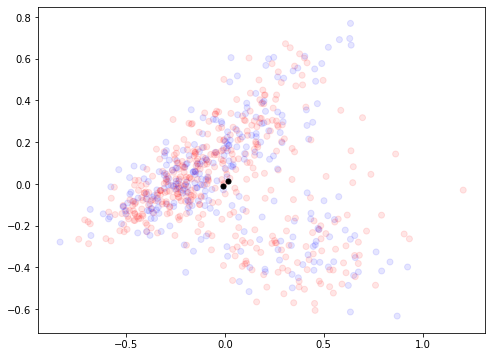

In [146]:
pca_y_plot(analyzer, conditions={'subject': 'abortion'}, sample_frac=1)

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LogNorm

In [133]:
def pca_y_plot(analyzer, conditions={}, sample_frac=0.1):
    cond_index = analyzer.cond_index(conditions).tolist()
    cond_df = analyzer.df.loc[cond_index]
    
    
    X, cond_y = analyzer.rmn.prep_X(cond_df, for_training=True)
    
    party_labels = np.array(
        analyzer.rmn.metadata_dict[PARTY]['tokenize'](cond_df[PARTY])).flatten()
    
    pca = PCA()
    pc = pca.fit_transform(cond_y)
    
    # report
    print("cumulative explained variance to component 5")
    print(np.round(np.cumsum(pca.explained_variance_ratio_), 3)[:5])
    
    pc_data = pd.DataFrame({
        "pc0": pc[:,0], 
        "pc1": pc[:,1], 
        "party_label": party_labels
    }).sample(frac=sample_frac).reset_index(drop=True)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pc_data['pc0'], pc_data['pc1'], c = pc_data['party_label'], 
                cmap=matplotlib.colors.ListedColormap(['red', 'blue']), alpha = 0.1)
    
    # plot centroids
    pc_sample = pc_data[['pc0', 'pc1']].to_numpy()
    
    R_lab = analyzer.rmn.metadata_dict['party']['token_index']['r']
    D_lab = analyzer.rmn.metadata_dict['party']['token_index']['d']
    
    D_index = pc_data[pc_data['party_label'] == D_lab].index.tolist()
    R_index = pc_data[pc_data['party_label'] == R_lab].index.tolist()
    
    D_x, D_y = pc_sample[D_index].mean(axis=0)
    R_x, R_y = pc_sample[R_index].mean(axis=0)
    
    
    #R_x, R_y = 
#     centroid_x = np.mean(cluster['principal component 1'])
#     centroid_y = np.mean(cluster['principal component 2'])
#     centroid = np.array([centroid_x, centroid_y]).reshape((2,1))
#     axes[index].plot(centroid[0], centroid[1], ms=5, marker='o', color = 'black')

    plt.plot(D_x, D_y, ms=5, marker='o', color='black')
    plt.plot(R_x, R_y, ms=5, marker='o', color='black')
    